In [1]:
# data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# torch
import torch
from torch.nn import Sigmoid
from torch.utils.data import DataLoader
from torch.optim import AdamW

# sklearn
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, balanced_accuracy_score

# huggingface
from datasets import load_from_disk, Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import load_dataset
from transformers import get_scheduler
from sentence_transformers import SentenceTransformer, util

# # utils
from tqdm.auto import tqdm
from pprint import pprint

/home/jovyan/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
MODEL_CKPT = 'roberta-base'
LR = 2e-5
BATCH_SIZE = 64
WEIGHT_DECAY = 0.01
DEVICE = 'cuda:3' if torch.cuda.is_available else 'cpu'
# torch.cuda.set_device(4)
# torch.cuda.current_device()

In [3]:
# labels
id2label = {0: 'Normal', 1: 'Toxic'}
label2id = {'Normal': 0, 'Toxic': 1}

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT,
                                                           num_labels=2,
                                                           id2label=id2label,
                                                           label2id=label2id)

model = model.to(DEVICE)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [5]:
def tokenize_data(batch):
    comment = batch['text']
    
    tokenized = tokenizer(
        comment,
        truncation=True,
        max_length=128,
#         return_overflowing_tokens=True,
        padding='max_length'
    )  

    return tokenized

### Training Phase 1

In [6]:
train = pd.read_csv('../../data/classification/jigsaw-self-cleaned/train.txt', sep='\t', names=['labels', 'text'])
test = pd.read_csv('../../data/classification/jigsaw-self-cleaned/test.txt', sep='\t', names=['labels', 'text'])
valid = pd.read_csv('../../data/classification/jigsaw-self-cleaned/valid.txt', sep='\t', names=['labels', 'text'])

In [7]:
train.head()

,labels,text
0,0,""" Please do not vandalize pages, as you did wi..."
1,1,""" Reverting for no reason I spent quite some t..."
2,0,story line is maybe not the most original or c...
3,1,YOu motherfucker Pablo.... you have a sorry be...
4,1,"GROUND UNTIL IT'S A BLOODY PULP, THEN PROCEEDS..."


In [8]:
toxics = DatasetDict({
    'train': Dataset.from_pandas(train[['text', 'labels']]),
    'validation': Dataset.from_pandas(valid[['text', 'labels']]),
    'test': Dataset.from_pandas(test[['text', 'labels']])
})

toxics

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 20194
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 5591
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 8375
    })
})

In [9]:
# examine a little bit
toxics['train'][0]

{'text': '" Please do not vandalize pages, as you did with this edit to Vincent ( disambiguation ). If you continue to do so, you will be blocked from editing. "',
 'labels': 0}

In [10]:
toxics_tokenized = toxics.map(tokenize_data, batched=True, remove_columns='text')
toxics_tokenized

  0%|          | 0/21 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 20194
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5591
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 8375
    })
})

In [11]:
sample = toxics_tokenized['train'][0]
print(tokenizer.decode(sample['input_ids']), f'label: {sample["labels"]}')
# [id2label[idx] for idx, label in enumerate(sample['labels']) if label == 1.0]

<s>" Please do not vandalize pages, as you did with this edit to Vincent ( disambiguation ). If you continue to do so, you will be blocked from editing. "</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad> label: 0


In [12]:
toxics_tokenized.set_format('torch')

In [13]:
trainloader = DataLoader(toxics_tokenized['train'], shuffle=True, batch_size=BATCH_SIZE)
devloader = DataLoader(toxics_tokenized['validation'], shuffle=False, batch_size=BATCH_SIZE)
testloader = DataLoader(toxics_tokenized['test'], shuffle=False, batch_size=BATCH_SIZE)

In [14]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

num_epochs = 10
num_train_steps = num_epochs * len(trainloader)
scheduler = get_scheduler('linear',
                         optimizer=optimizer,
                         num_warmup_steps=0,
                         num_training_steps=num_train_steps)

In [15]:
history = {}
for i in ['train', 'dev', 'test']:
    for j in ['loss', 'acc', 'f1', 'prec', 'rec']:
        history[f'{i}_{j}'] = []

In [16]:
progress_bar = tqdm(range(num_train_steps))

best_loss = float('inf')
for epoch in range(num_epochs):
    
    model.train()
    
    step_history = {}
    for i in ['train', 'dev', 'test']:
        for j in ['loss', 'acc', 'f1', 'prec', 'rec', 'rocauc']:
            step_history[f'{i}_{j}'] = 0
    
    for batch in trainloader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        outputs = model(**batch)
        labels = batch['labels'].cpu().numpy()
        
        logits = outputs.logits.squeeze().detach().cpu()
        probs = torch.sigmoid(logits)
        preds = torch.argmax(probs, dim=1).numpy()        
        
        loss = outputs.loss
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
        # logging
        step_history['train_loss'] += loss.item()
        step_history['train_acc'] += accuracy_score(labels, preds)
        step_history['train_f1'] += f1_score(labels, preds, average='micro')
        step_history['train_prec'] += precision_score(labels, preds, average='micro')
        step_history['train_rec'] += recall_score(labels, preds, average='micro')
        step_history['train_rocauc'] += roc_auc_score(labels, preds, average='micro')
        
    step_history['train_loss'] /= len(trainloader)
    step_history['train_acc'] /= len(trainloader)
    step_history['train_f1'] /= len(trainloader)
    step_history['train_prec'] /= len(trainloader)
    step_history['train_rec'] /= len(trainloader)
    step_history['train_rocauc'] /= len(trainloader)
    

    model.eval()
    with torch.no_grad():
        for dbatch in tqdm(devloader, leave=False, desc='Validation'):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            outputs = model(**batch)
            labels = batch['labels'].cpu().numpy()

            logits = outputs.logits.squeeze().detach().cpu()
            probs = torch.sigmoid(logits)
            preds = torch.argmax(probs, dim=1).numpy()        

            loss = outputs.loss
            
            # logging
            step_history['dev_loss'] += loss.item()
            step_history['dev_acc'] += accuracy_score(labels, preds)
            step_history['dev_f1'] += f1_score(labels, preds, average='micro')
            step_history['dev_prec'] += precision_score(labels, preds, average='micro')
            step_history['dev_rec'] += recall_score(labels, preds, average='micro')
            step_history['dev_rocauc'] += roc_auc_score(labels, preds, average='micro')
            
    step_history['dev_loss'] /= len(devloader)
    step_history['dev_acc'] /= len(devloader)
    step_history['dev_f1'] /= len(devloader)
    step_history['dev_prec'] /= len(devloader)
    step_history['dev_rec'] /= len(devloader)
    step_history['dev_rocauc'] /= len(devloader)
    
    if step_history['dev_loss'] <= best_loss:
        torch.save(model.state_dict(), '../model/robertoxic-classifier.pth')
    
    
    for key in history:
        history[key].append(step_history[key])
        
    print(step_history)

  0%|          | 0/3160 [00:00<?, ?it/s]

Validation:   0%|          | 0/88 [00:00<?, ?it/s]

{'train_loss': 0.2241340800176693, 'train_acc': 0.9134371509679822, 'train_f1': 0.9134371509679822, 'train_prec': 0.9134371509679822, 'train_rec': 0.9134371509679822, 'train_rocauc': 0.9063061896679518, 'dev_loss': 0.17617177963256836, 'dev_acc': 0.9117647058823525, 'dev_f1': 0.9117647058823525, 'dev_prec': 0.9117647058823525, 'dev_rec': 0.9117647058823525, 'dev_rocauc': 0.9131944444444432, 'test_loss': 0, 'test_acc': 0, 'test_f1': 0, 'test_prec': 0, 'test_rec': 0, 'test_rocauc': 0}


Validation:   0%|          | 0/88 [00:00<?, ?it/s]

{'train_loss': 0.15049702945295013, 'train_acc': 0.9468569666790767, 'train_f1': 0.9468569666790767, 'train_prec': 0.9468569666790767, 'train_rec': 0.9468569666790767, 'train_rocauc': 0.9448481919507241, 'dev_loss': 0.1628216654062271, 'dev_acc': 0.9411764705882333, 'dev_f1': 0.9411764705882333, 'dev_prec': 0.9411764705882333, 'dev_rec': 0.9411764705882333, 'dev_rocauc': 0.9409722222222231, 'test_loss': 0, 'test_acc': 0, 'test_f1': 0, 'test_prec': 0, 'test_rec': 0, 'test_rocauc': 0}


Validation:   0%|          | 0/88 [00:00<?, ?it/s]

{'train_loss': 0.11310520441023798, 'train_acc': 0.9617897198436336, 'train_f1': 0.9617897198436336, 'train_prec': 0.9617897198436336, 'train_rec': 0.9617897198436336, 'train_rocauc': 0.9604652502015433, 'dev_loss': 0.0628209337592125, 'dev_acc': 0.9705882352941163, 'dev_f1': 0.9705882352941163, 'dev_prec': 0.9705882352941163, 'dev_rec': 0.9705882352941163, 'dev_rocauc': 0.96875, 'test_loss': 0, 'test_acc': 0, 'test_f1': 0, 'test_prec': 0, 'test_rec': 0, 'test_rocauc': 0}


Validation:   0%|          | 0/88 [00:00<?, ?it/s]

{'train_loss': 0.08202102586267446, 'train_acc': 0.9735026526433359, 'train_f1': 0.9735026526433359, 'train_prec': 0.9735026526433359, 'train_rec': 0.9735026526433359, 'train_rocauc': 0.9725310112397654, 'dev_loss': 0.12175202369689941, 'dev_acc': 0.9705882352941163, 'dev_f1': 0.9705882352941163, 'dev_prec': 0.9705882352941163, 'dev_rec': 0.9705882352941163, 'dev_rocauc': 0.98, 'test_loss': 0, 'test_acc': 0, 'test_f1': 0, 'test_prec': 0, 'test_rec': 0, 'test_rocauc': 0}


Validation:   0%|          | 0/88 [00:00<?, ?it/s]

{'train_loss': 0.05545682546275939, 'train_acc': 0.9830021407297096, 'train_f1': 0.9830021407297096, 'train_prec': 0.9830021407297096, 'train_rec': 0.9830021407297096, 'train_rocauc': 0.9823284721592465, 'dev_loss': 0.14812436699867249, 'dev_acc': 0.9411764705882333, 'dev_f1': 0.9411764705882333, 'dev_prec': 0.9411764705882333, 'dev_rec': 0.9411764705882333, 'dev_rocauc': 0.9545454545454536, 'test_loss': 0, 'test_acc': 0, 'test_f1': 0, 'test_prec': 0, 'test_rec': 0, 'test_rocauc': 0}


Validation:   0%|          | 0/88 [00:00<?, ?it/s]

{'train_loss': 0.04201822642522829, 'train_acc': 0.9878362341772152, 'train_f1': 0.9878362341772152, 'train_prec': 0.9878362341772152, 'train_rec': 0.9878362341772152, 'train_rocauc': 0.9873133444666051, 'dev_loss': 0.004088368732482195, 'dev_acc': 1.0, 'dev_f1': 1.0, 'dev_prec': 1.0, 'dev_rec': 1.0, 'dev_rocauc': 1.0, 'test_loss': 0, 'test_acc': 0, 'test_f1': 0, 'test_prec': 0, 'test_rec': 0, 'test_rocauc': 0}


Validation:   0%|          | 0/88 [00:00<?, ?it/s]

{'train_loss': 0.028854813406470857, 'train_acc': 0.9921438709977662, 'train_f1': 0.9921438709977662, 'train_prec': 0.9921438709977662, 'train_rec': 0.9921438709977662, 'train_rocauc': 0.9919460831726403, 'dev_loss': 0.0029003534000366926, 'dev_acc': 1.0, 'dev_f1': 1.0, 'dev_prec': 1.0, 'dev_rec': 1.0, 'dev_rocauc': 1.0, 'test_loss': 0, 'test_acc': 0, 'test_f1': 0, 'test_prec': 0, 'test_rec': 0, 'test_rocauc': 0}


Validation:   0%|          | 0/88 [00:00<?, ?it/s]

{'train_loss': 0.021487822503446826, 'train_acc': 0.9941653481012658, 'train_f1': 0.9941653481012658, 'train_prec': 0.9941653481012658, 'train_rec': 0.9941653481012658, 'train_rocauc': 0.9940118290927072, 'dev_loss': 0.00228686211630702, 'dev_acc': 1.0, 'dev_f1': 1.0, 'dev_prec': 1.0, 'dev_rec': 1.0, 'dev_rocauc': 1.0, 'test_loss': 0, 'test_acc': 0, 'test_f1': 0, 'test_prec': 0, 'test_rec': 0, 'test_rocauc': 0}


Validation:   0%|          | 0/88 [00:00<?, ?it/s]

{'train_loss': 0.014761446147738614, 'train_acc': 0.9954509493670886, 'train_f1': 0.9954509493670886, 'train_prec': 0.9954509493670886, 'train_rec': 0.9954509493670886, 'train_rocauc': 0.9955194960524496, 'dev_loss': 0.0016202823026105762, 'dev_acc': 1.0, 'dev_f1': 1.0, 'dev_prec': 1.0, 'dev_rec': 1.0, 'dev_rocauc': 1.0, 'test_loss': 0, 'test_acc': 0, 'test_f1': 0, 'test_prec': 0, 'test_rec': 0, 'test_rocauc': 0}


Validation:   0%|          | 0/88 [00:00<?, ?it/s]

{'train_loss': 0.011522658074590013, 'train_acc': 0.9966492926284438, 'train_f1': 0.9966492926284438, 'train_prec': 0.9966492926284438, 'train_rec': 0.9966492926284438, 'train_rocauc': 0.9966845583095991, 'dev_loss': 0.0769820436835289, 'dev_acc': 0.9411764705882333, 'dev_f1': 0.9411764705882333, 'dev_prec': 0.9411764705882333, 'dev_rec': 0.9411764705882333, 'dev_rocauc': 0.9565217391304361, 'test_loss': 0, 'test_acc': 0, 'test_f1': 0, 'test_prec': 0, 'test_rec': 0, 'test_rocauc': 0}


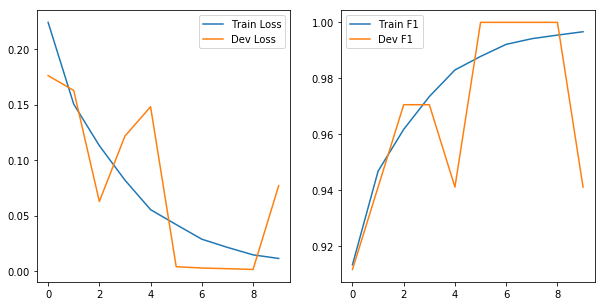

In [17]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(range(num_epochs), history['train_loss'], label='Train Loss')
ax[0].plot(range(num_epochs), history['dev_loss'], label='Dev Loss')
ax[0].legend()

ax[1].plot(range(num_epochs), history['train_f1'], label='Train F1')
ax[1].plot(range(num_epochs), history['dev_f1'], label='Dev F1')
ax[1].legend()

plt.show()

In [38]:
torch.save(model.state_dict(), '../model/robertoxic-classifier.pth')

### Finetuning Skoltech Jigsaw

In [8]:
model.load_state_dict(torch.load('../model/robertoxic-classifier.pth'))

<All keys matched successfully>

In [18]:
import os

raw_data = {}
DATA_PATH = '../../data/seq2seq/'

for file in os.listdir(DATA_PATH):
    if '.' not in file:
        continue
    meta_ = file.split('.')
    with open(DATA_PATH + file, 'r', encoding='utf-8') as f:        
#         raw_data[f'{file.replace(".", "_")}'] = [s.strip() for s in f.readlines()]
        data = [s.strip() for s in f.readlines()]
        labels = [1] * len(data) if meta_[1] == 'tox' else [0] * len(data)
        print(file, len(data))
    
    if meta_[0] not in raw_data.keys():
        raw_data[meta_[0]] = data
        raw_data[f'{meta_[0]}_labels'] = labels
    else:
        raw_data[meta_[0]].extend(data)
        raw_data[f'{meta_[0]}_labels'].extend(labels)

val.tox 6648
test.tox 10000
val.norm 6648
train.norm 135390
test.norm 10000
train.tox 135390


In [19]:
ft_train = pd.DataFrame(data={'text': raw_data['train'], 
                              'labels': raw_data['train_labels']})
ft_valid = pd.DataFrame(data={'text': raw_data['val'],
                              'labels': raw_data['val_labels']})
ft_test = pd.DataFrame(data={'text': raw_data['test'],
                             'labels': raw_data['test_labels']})

In [20]:
ft_train.labels.value_counts()

0    135390
1    135390
Name: labels, dtype: int64

In [21]:
ft_toxics = DatasetDict({
    'train': Dataset.from_pandas(ft_train[['text', 'labels']]),
    'validation': Dataset.from_pandas(ft_valid[['text', 'labels']]),
    'test': Dataset.from_pandas(ft_test[['text', 'labels']])
})

ft_toxics

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 270780
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 13296
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 20000
    })
})

In [22]:
ft_toxics_tokenized = ft_toxics.map(tokenize_data, batched=True, remove_columns='text')
ft_toxics_tokenized

  0%|          | 0/271 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 270780
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 13296
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 20000
    })
})

In [23]:
ft_sample = ft_toxics_tokenized['train'][5]
print(tokenizer.decode(ft_sample['input_ids']), f'label: {ft_sample["labels"]}')
# [id2label[idx] for idx, label in enumerate(sample['labels']) if label == 1.0]

<s>but i do have economic creds, so i know of which i speak.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad> label: 0


In [24]:
ft_toxics_tokenized.set_format('torch')

In [25]:
trainloader = DataLoader(ft_toxics_tokenized['train'], shuffle=True, batch_size=BATCH_SIZE)
devloader = DataLoader(ft_toxics_tokenized['validation'], shuffle=False, batch_size=BATCH_SIZE)
testloader = DataLoader(ft_toxics_tokenized['test'], shuffle=False, batch_size=BATCH_SIZE)

In [26]:
history = {}
for i in ['train', 'dev', 'test']:
    for j in ['loss', 'acc', 'f1', 'prec', 'rec']:
        history[f'ft_{i}_{j}'] = []

In [27]:
num_epochs = 3
num_train_steps = num_epochs * len(trainloader)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = get_scheduler('linear',
                         optimizer=optimizer,
                         num_warmup_steps=0,
                         num_training_steps=num_train_steps)

In [28]:
progress_bar = tqdm(range(num_train_steps))

best_loss = float('inf')
for epoch in range(num_epochs):
    
    model.train()
    
    step_history = {}
    for i in ['train', 'dev', 'test']:
        for j in ['loss', 'acc', 'f1', 'prec', 'rec', 'rocauc']:
            step_history[f'ft_{i}_{j}'] = 0
    
    for batch in trainloader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        outputs = model(**batch)
        labels = batch['labels'].cpu().numpy()
        
        logits = outputs.logits.squeeze().detach().cpu()
        probs = torch.sigmoid(logits)
        preds = torch.argmax(probs, dim=1).numpy()        
        
        loss = outputs.loss
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
        # logging
        step_history['ft_train_loss'] += loss.item()
        step_history['ft_train_acc'] += accuracy_score(labels, preds)
        step_history['ft_train_f1'] += f1_score(labels, preds, average='micro')
        step_history['ft_train_prec'] += precision_score(labels, preds, average='micro')
        step_history['ft_train_rec'] += recall_score(labels, preds, average='micro')
        step_history['ft_train_rocauc'] += roc_auc_score(labels, preds, average='micro')
        
    step_history['ft_train_loss'] /= len(trainloader)
    step_history['ft_train_acc'] /= len(trainloader)
    step_history['ft_train_f1'] /= len(trainloader)
    step_history['ft_train_prec'] /= len(trainloader)
    step_history['ft_train_rec'] /= len(trainloader)
    step_history['ft_train_rocauc'] /= len(trainloader)
    

    model.eval()
    with torch.no_grad():
        for dbatch in tqdm(devloader, leave=False, desc='Validation'):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            outputs = model(**batch)
            labels = batch['labels'].cpu().numpy()

            logits = outputs.logits.squeeze().detach().cpu()
            probs = torch.sigmoid(logits)
            preds = torch.argmax(probs, dim=1).numpy()        

            loss = outputs.loss
            
            # logging
            step_history['ft_dev_loss'] += loss.item()
            step_history['ft_dev_acc'] += accuracy_score(labels, preds)
            step_history['ft_dev_f1'] += f1_score(labels, preds, average='micro')
            step_history['ft_dev_prec'] += precision_score(labels, preds, average='micro')
            step_history['ft_dev_rec'] += recall_score(labels, preds, average='micro')
            step_history['ft_dev_rocauc'] += roc_auc_score(labels, preds, average='micro')
            
    step_history['ft_dev_loss'] /= len(devloader)
    step_history['ft_dev_acc'] /= len(devloader)
    step_history['ft_dev_f1'] /= len(devloader)
    step_history['ft_dev_prec'] /= len(devloader)
    step_history['ft_dev_rec'] /= len(devloader)
    step_history['ft_dev_rocauc'] /= len(devloader)
    
    if step_history['ft_dev_loss'] <= best_loss:
        torch.save(model.state_dict(), '../model/ft-robertoxic-classifier.pth')        
    
    for key in history:
        history[key].append(step_history[key])
        
    pprint(step_history)

  0%|          | 0/12693 [00:00<?, ?it/s]

Validation:   0%|          | 0/208 [00:00<?, ?it/s]

{'ft_dev_acc': 0.9499999999999973,
 'ft_dev_f1': 0.9499999999999973,
 'ft_dev_loss': 0.10859517008066177,
 'ft_dev_prec': 0.9499999999999973,
 'ft_dev_rec': 0.9499999999999973,
 'ft_dev_rocauc': 0.953125,
 'ft_test_acc': 0,
 'ft_test_f1': 0,
 'ft_test_loss': 0,
 'ft_test_prec': 0,
 'ft_test_rec': 0,
 'ft_test_rocauc': 0,
 'ft_train_acc': 0.9620905715748838,
 'ft_train_f1': 0.9620905715748838,
 'ft_train_loss': 0.11030269045289408,
 'ft_train_prec': 0.9620905715748838,
 'ft_train_rec': 0.9620905715748838,
 'ft_train_rocauc': 0.9620932626217615}


Validation:   0%|          | 0/208 [00:00<?, ?it/s]

{'ft_dev_acc': 1.0,
 'ft_dev_f1': 1.0,
 'ft_dev_loss': 0.020879248157143593,
 'ft_dev_prec': 1.0,
 'ft_dev_rec': 1.0,
 'ft_dev_rocauc': 1.0,
 'ft_test_acc': 0,
 'ft_test_f1': 0,
 'ft_test_loss': 0,
 'ft_test_prec': 0,
 'ft_test_rec': 0,
 'ft_test_rocauc': 0,
 'ft_train_acc': 0.9767157586858899,
 'ft_train_f1': 0.9767157586858899,
 'ft_train_loss': 0.07326065222592948,
 'ft_train_prec': 0.9767157586858899,
 'ft_train_rec': 0.9767157586858899,
 'ft_train_rocauc': 0.9767066900960252}


Validation:   0%|          | 0/208 [00:00<?, ?it/s]

{'ft_dev_acc': 0.9833333333333288,
 'ft_dev_f1': 0.9833333333333288,
 'ft_dev_loss': 0.021034590899944305,
 'ft_dev_prec': 0.9833333333333288,
 'ft_dev_rec': 0.9833333333333288,
 'ft_dev_rocauc': 0.9848484848484899,
 'ft_test_acc': 0,
 'ft_test_f1': 0,
 'ft_test_loss': 0,
 'ft_test_prec': 0,
 'ft_test_rec': 0,
 'ft_test_rocauc': 0,
 'ft_train_acc': 0.9840977802725912,
 'ft_train_f1': 0.9840977802725912,
 'ft_train_loss': 0.05454668200421172,
 'ft_train_prec': 0.9840977802725912,
 'ft_train_rec': 0.9840977802725912,
 'ft_train_rocauc': 0.9841389954592951}


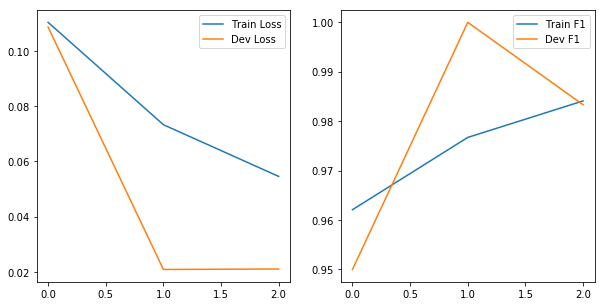

In [31]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(range(num_epochs), history['ft_train_loss'], label='Train Loss')
ax[0].plot(range(num_epochs), history['ft_dev_loss'], label='Dev Loss')
ax[0].legend()

ax[1].plot(range(num_epochs), history['ft_train_f1'], label='Train F1')
ax[1].plot(range(num_epochs), history['ft_dev_f1'], label='Dev F1')
ax[1].legend()

plt.show()

In [41]:
with torch.no_grad():
    for dbatch in tqdm(testloader, desc='Testing'):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        outputs = model(**batch)
        labels = batch['labels'].cpu().numpy()

        logits = outputs.logits.squeeze().detach().cpu()
        probs = torch.sigmoid(logits)
        preds = torch.argmax(probs, dim=1).numpy()        

        loss = outputs.loss

        # logging
        step_history['ft_test_loss'] += loss.item()
        step_history['ft_test_acc'] += accuracy_score(labels, preds)
        step_history['ft_test_f1'] += f1_score(labels, preds, average='micro')
        step_history['ft_test_prec'] += precision_score(labels, preds, average='micro')
        step_history['ft_test_rec'] += recall_score(labels, preds, average='micro')
        step_history['ft_test_rocauc'] += roc_auc_score(labels, preds, average='micro')
        
step_history['ft_test_loss'] /= len(testloader)
step_history['ft_test_acc'] /= len(testloader)
step_history['ft_test_f1'] /= len(testloader)
step_history['ft_test_prec'] /= len(testloader)
step_history['ft_test_rec'] /= len(testloader)
step_history['ft_test_rocauc'] /= len(testloader)

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

In [42]:
step_history

{'ft_train_loss': 0.05454668200421172,
 'ft_train_acc': 0.9840977802725912,
 'ft_train_f1': 0.9840977802725912,
 'ft_train_prec': 0.9840977802725912,
 'ft_train_rec': 0.9840977802725912,
 'ft_train_rocauc': 0.9841389954592951,
 'ft_dev_loss': 0.021034590899944305,
 'ft_dev_acc': 0.9833333333333288,
 'ft_dev_f1': 0.9833333333333288,
 'ft_dev_prec': 0.9833333333333288,
 'ft_dev_rec': 0.9833333333333288,
 'ft_dev_rocauc': 0.9848484848484899,
 'ft_test_loss': 0.021034590899944305,
 'ft_test_acc': 0.9833333333333307,
 'ft_test_f1': 0.9833333333333307,
 'ft_test_prec': 0.9833333333333307,
 'ft_test_rec': 0.9833333333333307,
 'ft_test_rocauc': 0.9848484848484929}

In [43]:
torch.save(model.state_dict(), '../model/ft-robertoxic-classifier.pth')

### Infer on generated dataset

In [6]:
model = load_checkpoint('../model/ft-robertoxic-classifier.pth', model=model)

Load checkpoint


In [50]:
train_ruen = pd.read_csv('../../data/backtranslation/ruen_train.txt', sep='\t', index_col=0)
dev_ruen = pd.read_csv('../../data/backtranslation/ruen_valid.txt', sep='\t', index_col=0)
test_ruen = pd.read_csv('../../data/backtranslation/ruen_test.txt', sep='\t', index_col=0)

In [52]:
train_ruen.head()

,translated,original,source
0,"Fuck you, you nixon idiot.","Пошел ты на хуй, никсонский болван.","fuck you , you nixonian twit ."
1,"Just another angry and dirty anti-tramp, cool ...","просто еще один злобный и грязный антитрамп, п...","just another vicious and trashy antitrump , pr..."
2,"If you want to talk to the hypocrites, Bauer, ...","Если ты хочешь поговорить с лицемерами, Бауэр,...","if you want to talk hypocrites , bauer , im up..."
3,The fact that you were shocked by the reaction...,"То, что ты был шокирован ответной реакцией, ли...",that you were shocked by the backlash only fur...
4,You all suck the shit out of Shapiros and lick...,Вы все сосёте хуй шапироса и лижете его маму!,you all suck shapiros cock and lick his mother...


In [54]:
# remap and reorder columns
train_ruen.rename(columns={'translated': 'backtranslate', 'original': 'translate'}, inplace=True)
train_ruen = train_ruen[['source', 'translate', 'backtranslate']]

dev_ruen.rename(columns={'translated': 'backtranslate', 'original': 'translate'}, inplace=True)
dev_ruen = dev_ruen[['source', 'translate', 'backtranslate']]

test_ruen.rename(columns={'translated': 'backtranslate', 'original': 'translate'}, inplace=True)
test_ruen = test_ruen[['source', 'translate', 'backtranslate']]

In [55]:
ruen_toxics = DatasetDict({
    'train': Dataset.from_pandas(train_ruen[['backtranslate']]),
    'validation': Dataset.from_pandas(dev_ruen[['backtranslate']]),
    'test': Dataset.from_pandas(test_ruen[['backtranslate']])
})

In [56]:
def tokenize_data(batch):
    comment = batch['backtranslate']
    
    tokenized = tokenizer(
        comment,
        truncation=True,
        max_length=128,
        padding='max_length'
    )

    return tokenized

In [57]:
ruen_toxics_tokenized = ruen_toxics.map(tokenize_data, batched=True)
ruen_toxics_tokenized

  0%|          | 0/136 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['backtranslate', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 135390
    })
    validation: Dataset({
        features: ['backtranslate', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 6648
    })
    test: Dataset({
        features: ['backtranslate', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
})

In [58]:
ruen_toxics_tokenized.set_format('torch')

In [59]:
trainruenloader = DataLoader(ruen_toxics_tokenized['train'], shuffle=False, batch_size=BATCH_SIZE)
devruenloader = DataLoader(ruen_toxics_tokenized['validation'], shuffle=False, batch_size=BATCH_SIZE)
testruenloader = DataLoader(ruen_toxics_tokenized['test'], shuffle=False, batch_size=BATCH_SIZE)

In [60]:
ruen_trainpreds = []
ruen_devpreds = []
ruen_testpreds = []

for batch in tqdm(trainruenloader, desc='Trainset Inference'):
    batch = {k: v.to(DEVICE) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
    out = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
    
    logits = out.logits.squeeze().detach().cpu()
    probs = torch.sigmoid(logits)
    preds = torch.argmax(probs, dim=1).numpy()    
    
    ruen_trainpreds.extend(preds.tolist())
    

for batch in tqdm(devruenloader, desc='Devset Inference'):
    batch = {k: v.to(DEVICE) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
    out = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
    
    logits = out.logits.squeeze().detach().cpu()
    probs = torch.sigmoid(logits)
    preds = torch.argmax(probs, dim=1).numpy()
    
    ruen_devpreds.extend(preds.tolist())
    

for batch in tqdm(testruenloader, desc='Testset Inference'):
    batch = {k: v.to(DEVICE) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
    out = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
    
    logits = out.logits.squeeze().detach().cpu()
    probs = torch.sigmoid(logits)
    preds = torch.argmax(probs, dim=1).numpy()
    
    ruen_testpreds.extend(preds.tolist())

Trainset Inference:   0%|          | 0/2116 [00:00<?, ?it/s]

Devset Inference:   0%|          | 0/104 [00:00<?, ?it/s]

Testset Inference:   0%|          | 0/157 [00:00<?, ?it/s]

In [36]:
# devpreds = []

# for batch in tqdm(devbtloader):
#     batch = {k: v.to(DEVICE) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
#     out = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
    
#     logits = out.logits.squeeze().detach().cpu()
#     probs = torch.sigmoid(logits)
#     preds = torch.argmax(probs, dim=1).numpy()
    
#     devpreds.extend(preds.tolist())

  0%|          | 0/39 [00:00<?, ?it/s]

In [37]:
# testpreds = []

# for batch in tqdm(testbtloader):
#     batch = {k: v.to(DEVICE) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
#     out = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
    
#     logits = out.logits.squeeze().detach().cpu()
#     probs = torch.sigmoid(logits)
#     preds = torch.argmax(probs, dim=1).numpy()
    
#     testpreds.extend(preds.tolist())

  0%|          | 0/58 [00:00<?, ?it/s]

In [62]:
train_ruen['ruen_preds'] = ruen_trainpreds
dev_ruen['ruen_preds'] = ruen_devpreds
test_ruen['ruen_preds'] = ruen_testpreds

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [65]:
train_ruen[train_ruen['ruen_preds'] == 0]

,source,translate,backtranslate,ruen_preds
16,this dok is an embarrassment to every normal c...,Эта доска - позор для каждого нормального кана...,This board is a shame for every normal Canadian.,0
70,do people really wonder why the world seems so...,"Неужели люди действительно удивляются, почему ...",Do people really wonder why the world seems so...,0
78,so move to mexico liberal loser !,Так что двигайся к либералу-мексико!,So move on to liberal mexico!,0
94,"but with a man , off with his head !","Но с мужчиной, со своей головой!","But with a man, with his head!",0
104,get your own damn school and do what you want ...,"Получи свою школу и делай, что хочешь, без мои...","Get your school and do whatever you want, with...",0
...,...,...,...,...
135365,muslims no worse than any other ? .,Муслимы не хуже других?,The Muslims are as good as the others?,0
135370,mental midgets think that the chain saw is the...,"Умные карлики думают, что цепная пила - единст...",Smart dwarfs think chain saw is the only way t...,0
135372,a fine and fair comparison is comparing your b...,Прекрасное и справедливое сравнение - это срав...,A beautiful and fair comparison is a compariso...,0
135384,"last but not least , it seems like of recent o...","И последнее, но не менее важное, похоже, что н...","Last but not least, it seems that our jump rec...",0


In [40]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(vocabulary=tokenizer.vocab)
train_trans_vec = tfidf.fit_transform(train_bt['backtranslate']).toarray()
train_source_vec = tfidf.fit_transform(train_bt['source']).toarray()

dev_trans_vec = tfidf.fit_transform(dev_bt['backtranslate']).toarray()
dev_source_vec = tfidf.fit_transform(dev_bt['source']).toarray()

test_trans_vec = tfidf.fit_transform(test_bt['backtranslate']).toarray()
test_source_vec = tfidf.fit_transform(test_bt['source']).toarray()

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"
/home/jovyan/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"
/home/jovyan/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"
/home/jovyan/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents

In [43]:
train_sim = []
dev_sim = []
test_sim = []

for trans, src in tqdm(zip(train_trans_vec, train_source_vec)):
    train_sim.append(cosine_similarity(trans, src))
    
for trans, src in tqdm(zip(dev_trans_vec, dev_source_vec)):
    dev_sim.append(cosine_similarity(trans, src))
    
for trans, src in tqdm(zip(test_trans_vec, test_source_vec)):
    test_sim.append(cosine_similarity(trans, src))

0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [44]:
train_bt['similarity'] = train_sim
dev_bt['similarity'] = dev_sim
test_bt['similarity'] = test_sim

In [45]:
train_bt_selected = train_bt[(train_bt.bt_preds == 0) & (train_bt.similarity <= .725)]
dev_bt_selected = dev_bt[(dev_bt.bt_preds == 0) & (dev_bt.similarity <= .725)]
test_bt_selected = test_bt[(test_bt.bt_preds == 0) & (test_bt.similarity <= .725)]

In [47]:
df_paraphrase_ref = pd.concat([train_bt_selected, dev_bt_selected, test_bt_selected])
df_paraphrase_ref.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2081 entries, 40 to 3624
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   source         2081 non-null   object 
 1   translate      2081 non-null   object 
 2   backtranslate  2081 non-null   object 
 3   bt_preds       2081 non-null   int64  
 4   similarity     2081 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 97.5+ KB


In [256]:
df_paraphrase_ref.to_csv('../data/paraphrase/paraphrase_ref.csv', sep='\t', index=False, header=True)

In [50]:
train_bt.to_csv('../data/paraphrase/train_prep_paraphrase.txt', sep='\t', index=False, header=True)
dev_bt.to_csv('../data/paraphrase/valid_prep_paraphrase.txt', sep='\t', index=False, header=True)
test_bt.to_csv('../data/paraphrase/test_prep_paraphrase.txt', sep='\t', index=False, header=True)

##### Calculate semantic similarity

In [3]:
stmodel = SentenceTransformer('all-MiniLM-L6-v2')
stmodel = stmodel.to(DEVICE)

In [4]:
df_paraphrase_ref = pd.read_csv('../data/paraphrase/paraphrase_ref.csv', sep='\t')
train_bt = pd.read_csv('../data/paraphrase/train_prep_paraphrase.txt', sep='\t')
dev_bt = pd.read_csv('../data/paraphrase/valid_prep_paraphrase.txt', sep='\t')
test_bt = pd.read_csv('../data/paraphrase/test_prep_paraphrase.txt', sep='\t')

In [11]:
class SemanticDataset(Dataset):
    def __init__(self, path, base_dir='../data/paraphrase/'):
        
        self.data_list = []
        
        self.path = os.path.join(base_dir, path)
        
        data = pd.read_csv(self.path, sep='\t')
        for row in tqdm(data.iterrows()):
            self.data_list.append({
                'source': row[1].source,
                'backtrans': row[1].backtranslate
            })
            
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, item):
        return self.data_list[item]

In [16]:
trainbt_dataset = SemanticDataset('train_prep_paraphrase.txt')
devbt_dataset = SemanticDataset('valid_prep_paraphrase.txt')
testbt_dataset = SemanticDataset('test_prep_paraphrase.txt')

trainbt_loader = DataLoader(trainbt_dataset, batch_size=BATCH_SIZE, shuffle=False)
devbt_loader = DataLoader(devbt_dataset, batch_size=BATCH_SIZE, shuffle=False)
testbt_loader = DataLoader(testbt_dataset, batch_size=BATCH_SIZE, shuffle=False)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [21]:
train_stsim = []

for batch in tqdm(trainbt_loader):
    source = batch['source']
    backtrans = batch['backtrans']
    src_embed = stmodel.encode(source, convert_to_tensor=True)
    bts_embed = stmodel.encode(backtrans, convert_to_tensor=True)
    scores = util.cos_sim(src_embed, bts_embed)
    
    for i in range(len(source)):
        train_stsim.append(scores[i][i].item())
        
    torch.cuda.empty_cache()
    del src_embed
    del bts_embed

  0%|          | 0/782 [00:00<?, ?it/s]

In [27]:
dev_stsim = []

for batch in tqdm(devbt_loader):
    source = batch['source']
    backtrans = batch['backtrans']
    src_embed = stmodel.encode(source, convert_to_tensor=True)
    bts_embed = stmodel.encode(backtrans, convert_to_tensor=True)
    scores = util.cos_sim(src_embed, bts_embed)
    
    for i in range(len(source)):
        dev_stsim.append(scores[i][i].item())
        
    torch.cuda.empty_cache()
    del src_embed
    del bts_embed

  0%|          | 0/39 [00:00<?, ?it/s]

In [28]:
test_stsim = []

for batch in tqdm(testbt_loader):
    source = batch['source']
    backtrans = batch['backtrans']
    src_embed = stmodel.encode(source, convert_to_tensor=True)
    bts_embed = stmodel.encode(backtrans, convert_to_tensor=True)
    scores = util.cos_sim(src_embed, bts_embed)
    
    for i in range(len(source)):
        test_stsim.append(scores[i][i].item())
        
    torch.cuda.empty_cache()
    del src_embed
    del bts_embed

  0%|          | 0/58 [00:00<?, ?it/s]

In [32]:
train_bt['sem_similarity'] = train_stsim
dev_bt['sem_similarity'] = dev_stsim
test_bt['sem_similarity'] = test_stsim

In [33]:
train_bt.head()

,source,translate,backtranslate,bt_preds,similarity,sem_similarity
0,take your admin powers and stick them up your ...,Бери свои административные способности и засун...,Take your administrative skills and shove them...,1,0.654044,0.797628
1,you just made a fool of yourself .,Ты только что выставил себя дураком.,You just made a fool of yourself.,1,0.999817,1.000000
2,this animal killer is paying his share .,Этот зверь-убийца платит свою долю.,This killer animal is paying its share.,1,0.903200,0.950419
3,so you voted for the loser ?,"Значит, вы проголосовали за неудачника?",So you voted for the loser?,1,0.999822,1.000000
4,", but we would not expect a bias lib troll lik...",", но мы бы не ожидали, что такой пристрастный ...",but we wouldn't expect a biased troll like you...,1,0.425269,0.828127


In [61]:
train_bt_selected = train_bt[(train_bt.bt_preds == 0) & (train_bt.sem_similarity < 0.48)]
dev_bt_selected = dev_bt[(dev_bt.bt_preds == 0)]
test_bt_selected = test_bt[(test_bt.bt_preds == 0)]

In [56]:
df_paraphrase_ref = pd.concat([train_bt_selected, dev_bt_selected, test_bt_selected])
df_paraphrase_ref.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3233 entries, 6 to 3624
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   source          3233 non-null   object 
 1   translate       3233 non-null   object 
 2   backtranslate   3233 non-null   object 
 3   bt_preds        3233 non-null   int64  
 4   similarity      3206 non-null   float64
 5   sem_similarity  3233 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 176.8+ KB


In [60]:
df_paraphrase_ref[df_paraphrase_ref['similarity'].isnull()]

,source,translate,backtranslate,bt_preds,similarity,sem_similarity
633,obama has defecated on israel repeatedly .,Обама неоднократно обезвоживала Израэля.,Obama dehydrated Israel repeatedly.,0,NaN,0.716210
830,bla bla bla you can spin yourself stupid all y...,"Бла-бла-бла, ты можешь крутить себя глупо, ско...","Blah, blah, blah, blah, blah, blah, blah, blah...",0,NaN,0.244442
1216,waah screams the butthurt commie loser !,"Ваа кричит задница, музыка-неудачник!","Whoa, whoa, whoa, whoa, whoa, whoa, whoa, whoa...",0,NaN,0.228463
1744,ive had it up to here with idiots who want poo...,.................................................,.................................................,0,NaN,0.138859
6501,"paul martin , stephen harper , brian mulroney ...","Пол Мартин, Стефен Харпер, Брайан Мулрони (он ...","Paul Martin, Stephen Harper, Brian Mulroni.",0,NaN,0.813203
6745,muslim ban rejected by DIGIT ororfederal court...,)................................................,(i.e. ),0,NaN,0.066378
8084,"recycled , retread , useless lifers .","Рециркуляция, восстановление протектора, беспо...","Recirculation, retreading, useless life-saving...",0,NaN,0.617553
10520,slang a man who is unpleasant or not to be tru...,:................................................,:...............................,0,NaN,0.097186
11426,"ulysses simpson grant , the drunkard !","Улисс Симпсон Грант, пьяница!","Ulysses Simpson Grant, drunk!",0,NaN,0.933305
11873,i dont refute unhinged blather .,Я не опровергаю бессердечный блейтер.,I'm not denying a heartless blather.,0,NaN,0.646244
